Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
d =  9
Set  1 accuracy_score:  1.0
Set  2 accuracy_score:  0.9666666666666667
Set  3 accuracy_score:  0.8333333333333334
Set  4 accuracy_score:  0.4142857142857143
Set  5 accuracy_score:  0.24210526315789474


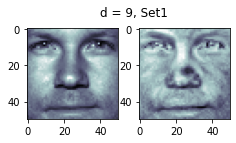

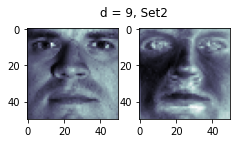

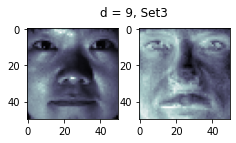

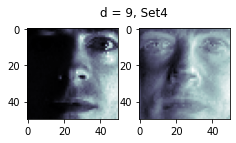

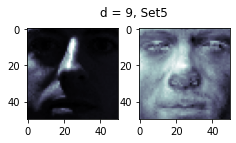

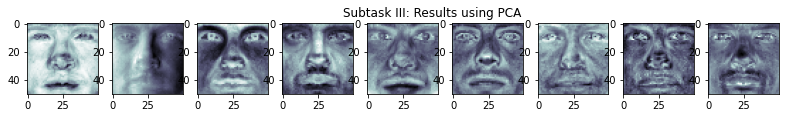

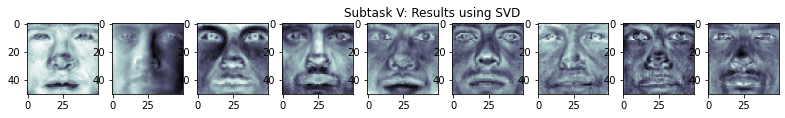

d =  30
Set  1 accuracy_score:  1.0
Set  2 accuracy_score:  0.9833333333333333
Set  3 accuracy_score:  0.9916666666666667
Set  4 accuracy_score:  0.8357142857142857
Set  5 accuracy_score:  0.5


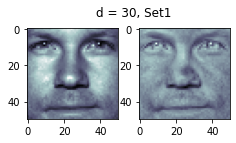

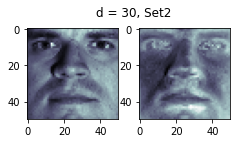

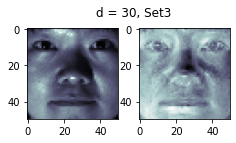

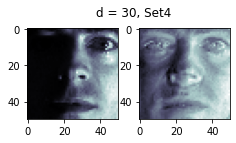

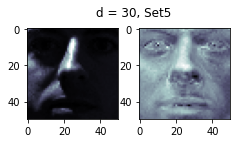

In [4]:
import numpy as np
import glob
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from random import seed
from random import randint
import matplotlib.pyplot as plt

# Mount the google drive to have access to the files
from google.colab import drive
drive.mount('/content/gdrive') 

DATASET_LOCATION = r'/content/gdrive/MyDrive/faces'

#get a picture set
def get_set(set_number):
  return{
      "Set_1": [1,7],
      "Set_2": [8,19],
      "Set_3": [20,31],
      "Set_4": [32,45],
      "Set_5": [46,64]
  }[set_number]

#convert an image to a vector and return it's size
def get_img_size(path):
  for image in glob.glob(path + '/*.png'):
    img = Image.open(image)
    arr = np.array(img)
    break
  return arr.size

#get a random image from a given set
def rand_img_from_set(set_number):
  seed(1)
  begin,end = get_set(set_number)
  person = randint(0,9)
  #person number + photo position
  picture = person*(end-begin+1) + randint(begin-1,end-1)

  return picture

#load images from a given set - SUBTASK I
def loadImages(path, set_number):
  
  size = get_img_size(path)
  matr = np.empty((0,size))

  pic_set = []
  labels = []
  begin, end= get_set(set_number)
  
  count = begin
  while(count <= end):    #get the boundaries of images indexes for given set
    pic_set.append(count)
    count = count + 1
  
  for image in glob.glob(path + '/*.png'): #access images in given path

    cur_path = image[-6:-4]
    if begin <= int(cur_path) <= end:
      matr_tmp = []
      img = Image.open(image)
      arr = np.array(img)
      b = arr.reshape(1,-1)               
      matr = np.append(matr, b, axis = 0) 
      labels.append(int(image[-9:-7]))

  return matr, labels  

#train the model - SUBTASK II
def train_model(arr, labels, d):                    
  pca = PCA(n_components=d, whiten=True).fit(arr)
  eigvecs_pca = pca.components_

  svd = TruncatedSVD(n_components=d).fit(arr)
  eigvecs_svd = svd.components_

  components = pca.transform(arr)
  model = KNeighborsClassifier(n_neighbors=1)
  model.fit(components, labels)
  
  return model, pca, eigvecs_pca, eigvecs_svd

#plot a random picture and it's corresponding reconstructed picture
#observe the results
def plot_rand_pic(initial_pic, reconst_pic, d, set_num):
  resh_init_pic = initial_pic.reshape(50,50)
  resh_reconst_pic = reconst_pic.reshape(50,50)

  plt.figure(figsize=(100,100))
  plt.suptitle("d = %d" %d + ", Set%d" %set_num, x=0.14,y=0.883)
  plt.subplot(50,50,1)
  plt.imshow(resh_init_pic, cmap='bone')
  plt.subplot(50,50,2)
  plt.imshow(resh_reconst_pic, cmap='bone')

#depict given singular vectors - used in SUBTASK III and V
def plot_images(eigvecs, method):
  
  plt.figure(figsize=(15,15))
  if method == "PCA":
    subtask_num = "III"
  else:
    subtask_num = "V"

  plt.suptitle("Subtask %s: " %subtask_num + "Results using %s" %method, y=0.55)
  for i in range(1,10,1):
    plt.subplot(1,10,i)
    plt.imshow(eigvecs[i-1].reshape(50,50), cmap='bone')
  plt.show()


scaler = StandardScaler() #subtract with mean value and devide by standard deviation 
d=[9,30]

for comp in d:            #for every d value
  print("d = ", comp)
  for i in range(1,6):    #for every image set
    #load images of current set, store them as vectors in an array - get the corresponding labels
    arr, labels = loadImages(DATASET_LOCATION, "Set_" + str(i))
    #standardize the array's values using standard scaler
    scaled_arr = scaler.fit_transform(arr)
    if i == 1:  #we use the first set to train our model
      model, pca, eigvecs_pca, eigvecs_svd = train_model(scaled_arr, labels, comp)
    
    #transform the data to the new axis system
    components = pca.transform(scaled_arr)
    #predict using KNeighborsClassifier
    y_pred = model.predict(components)
    #get the accuracy score for current set
    print("Set ", i, "accuracy_score: ", accuracy_score(labels, y_pred))
    #pick a random image from the current set
    pic_index = rand_img_from_set("Set_" + str(i))
    #recontstruct the image
    reconst_pic = pca.inverse_transform(components[pic_index])
    #and plot the results
    plot_rand_pic(arr[pic_index], reconst_pic, comp, i)
  
  if comp == 9:
    plot_images(eigvecs_pca, "PCA") #depict 9 top eigenvectors using pca
    plot_images(eigvecs_svd, "SVD") #depict 9 top singular vectors using svd
  

**NOTES**

A) our dataset is the faces directory, that contains our images.

B)The image sets are split to the following subseys:

Set_1: person*_01.png έως person*_07.png (first 7 images of each person's face)

Set_2: person*_08.png έως person*_19.png

Set_3: person*_20.png έως person*_31.png

Set_4: person*_32.png εως person*_45.png

Set_5: person*_46.png έως person*_64.png

C) Subtask III: Depict 9 top eigenvectors using pca
   Subtask V: Depict 9 top eigenvectors using svd

D) Results: After running the code cell above, we see a number of image pairs. For each of these pairs, image on the left is the true image, and image on the right is the same image, after being projected to the lower dimensional space and reconstructed back to it's initial dimensions.

**OBSERVATIONS - COMMENTS**

A) We can distinguish 10 separate sets for the given dataset. Each of these sets consists of the images that represent each person's face(person 1...10). For each of these sets, we can observe that, as me move from the first set to the next sets, images tend to be darker.

We can use this observation to explain the classification accuracy of our model for each image set, that will be shown by running the code cell above.

Of course, classification accuracy for Set_1 is 100%, since Set_1 is used to train the model. In the next sets, the value of this metric tends to be declined (in general). This happens because, as the images in the next sets become darker and darker, it makes it harder for the model to classify them to the correct label-person.

Finally, we can see that the accuracy rates for d=30(where d are the dimensions of the eigenspace that the images are projected), are better than the corresponding rates using d=9. We expect this to happen, because the higher the dimensions that we use to project the images, the more features we extract of each of them. As a result, it is easier for our model to classify them correctly to their corresponding label.

B) We can note that the reconstruction of the images from the lower-dimension space is more accurate if we use d=30 instead of d=9. We can also note that we can achieve quite an accurate representation of the Set_1 image, especially if we use d=30. As we move to the next sets and images become darker, the quality of the reconstructed images tends to become lower. This comes in accordance with our observations on A regarding to the model's classifiacation accuracy and can be explained in the same way.

C) There are no significant differences between the singular vectors that emerged after implementing the svd method and the eigenvectors that emerged after implementing eigenfaces method. We can observe that in their corresponding depictions, after running the above code cell.